In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from DataGenerator import DataGenerator
from Model import build_hf_model_only

img_size = 64


dg = DataGenerator()
dg.gen_one()
t_img = tf.convert_to_tensor(dg.output_img, dtype = tf.float32)
ds = tf.data.Dataset.from_tensor_slices(([t_img], [t_img]))



for i in range(30000):
    dg.gen_one()
    t_img = tf.convert_to_tensor(dg.output_img, dtype = tf.float32)
    ds = ds.concatenate(tf.data.Dataset.from_tensor_slices(([t_img], [t_img])))

print(ds)

BUFFER_SIZE = 100
BATCH_SIZE = 40
EPOCHS = 40

ds = ds.shuffle(buffer_size=BUFFER_SIZE,
                reshuffle_each_iteration=False)

ds_valid = ds.take(BATCH_SIZE).batch(BATCH_SIZE)
ds_train = ds.skip(BATCH_SIZE).batch(BATCH_SIZE)



<ConcatenateDataset shapes: ((64, 64, 1), (64, 64, 1)), types: (tf.float32, tf.float32)>


In [ ]:
from Model import build_hf_model_only
from Model import intensity_loss
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K

def lr_scheduler(epoch, lr):
    if (epoch % 10 == 0) & (epoch != 0):
        return lr/2
    return lr

model = build_hf_model_only(input_shape=(img_size, img_size, 1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=intensity_loss,
              metrics='accuracy')

callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]

history = model.fit(ds_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    validation_data=ds_valid,
                    shuffle=True)

hist = history.history

x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
plt.show()

Text(0.5, 0.92, 'True Surface')

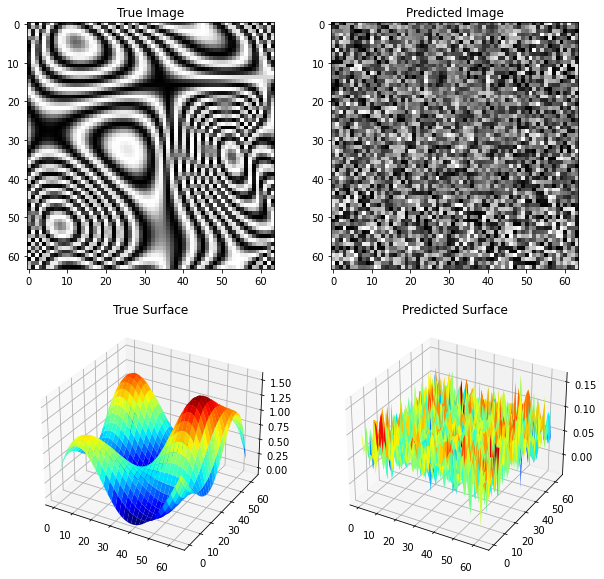

In [9]:
from DataGenerator import DataGenerator
import matplotlib.pyplot as plt

dg = DataGenerator()
dg.gen_one()

img = dg.output_img
img_ds = tf.data.Dataset.from_tensor_slices([[img]])
output_net = model.predict(img_ds)
output_net = output_net.reshape(img_size, img_size, 1)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 2, 4, projection='3d')
X, Y = np.meshgrid(range(0, dg.last_g.shape[0]), range(0, dg.last_g.shape[1]))
ax1.plot_surface(X, Y, output_net[:, :, 0], cmap='jet')
ax1.set_title('Predicted Surface')

ax2 = fig.add_subplot(2, 2, 2)
pred_img = dg.reprojector.intensity_reproject(img_array=img, h_map_array=output_net[:, :, 0])
ax2.imshow(pred_img, cmap='gray')
ax2.set_title('Predicted Image')

ax3 = fig.add_subplot(2, 2, 1)
ax3.imshow(img, cmap='gray')
ax3.set_title('True Image')

ax4 = fig.add_subplot(2, 2, 3, projection='3d')
ax4.plot_surface(X, Y, dg.last_g, cmap='jet')
ax4.set_title('True Surface')
